In [1]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from psmiles import PolymerSmiles as PS
from torch.utils.data import DataLoader, Dataset, random_split
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
from scipy.sparse import csr_matrix, lil_matrix
import atomInSmiles
from collections import Counter
from IPython.display import clear_output, display
import ipywidgets as widgets
from tqdm.notebook import tqdm
import os
import sys
import matplotlib.pyplot as plt
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print(device)
# os.chdir("C:\\Users\\user\\test.venv")
# print(os.getcwd())
from sklearn.preprocessing import MinMaxScaler

cuda


In [2]:
from sklearn.decomposition import PCA
mm_scaler = MinMaxScaler()
class load_data(Dataset):
    def __init__(self, path):
        #csv 읽기
        self.raw = pd.read_csv(path)

        #SMILES
        self.SMILES = self.raw.iloc[:, 1:2].values
        self.SMILES = np.squeeze(self.SMILES)

        #Li-ion Conductivity
        self.conductivity = self.raw.iloc[:, 6:7].values
        self.conductivity = mm_scaler.fit_transform(self.conductivity.reshape(-1, 1))

        #Degree of Polymerization
        self.DP = self.raw.iloc[:, 4:5].values
        self.DP = mm_scaler.fit_transform(self.DP.reshape(-1, 1))

        #Transfer Number
        self.tn = self.raw.iloc[:, 10:11].values
        self.tn = mm_scaler.fit_transform(self.tn.reshape(-1, 1))

        self.properties = np.concat((self.conductivity, self.DP, self.tn), axis=-1)

        #PSMILES 변환
        psmiles = []
        for smiles in self.SMILES:
            ps = PS(smiles)
            ps.canonicalize
            psmiles.append(ps.psmiles)

        #Atom-In-SMILES Encoding
        ais_encoding = []
        for smiles in psmiles:
            ais_encoding.append(atomInSmiles.encode(smiles))
        

        #Atom-In-SMILES Tokenization (Encoder)
        ais_tokens = []
        for smiles in ais_encoding:
            ais_tokens.append(atomInSmiles.smiles_tokenizer("[SOS] " + smiles +" [EOS]"))

        max_len = len(max(ais_encoding, key=len)) + 1
        self.max_len = max_len
        print("max sequence length : ", max_len)

        #vocab 구성
        corpus = []
        for frags in ais_tokens:
            corpus.extend(frags)
        token_count = Counter(corpus)
        vocab = { token:i for i, (token, count) in enumerate(sorted(token_count.items(), key=lambda x: x[1], reverse=True))}
        vocab_size = len(vocab)
        
        self.vocab = vocab

        num_data = len(ais_tokens)
        print(vocab)

        ais_tokens_enc = ais_tokens
        ais_tokens_enc = [[tok for tok in tokens if tok not in ['[SOS]', '[EOS]']] for tokens in ais_tokens_enc]

        ais_tokens_dec_input = ais_tokens
        ais_tokens_dec_input = [[tok for tok in tokens if tok not in ['[EOS]']] for tokens in ais_tokens_dec_input]

        ais_tokens_dec_output = ais_tokens
        ais_tokens_dec_output = [[tok for tok in tokens if tok not in ['[SOS]']] for tokens in ais_tokens_dec_output]

        #Tokens to number (encoder)
        ais_token_num_enc = torch.zeros((num_data, max_len), dtype=torch.long)
        i=0
        for tokens in ais_tokens_enc:
            for length in range((len(tokens))):
                ais_token_num_enc[i, length] = vocab[tokens[length]]
            i += 1

        #Tokens to number (Decoder Input)
        ais_token_num_dec_input = torch.zeros((num_data, max_len), dtype=torch.long)
        i=0
        for tokens in ais_tokens_dec_input:
            for length in range((len(tokens))):
                ais_token_num_dec_input[i, length] = vocab[tokens[length]]
            i += 1

        #Tokens to number (Decoder Output)
        ais_token_num_dec_output = torch.zeros((num_data, max_len), dtype=torch.long)
        i=0
        for tokens in ais_tokens_dec_output:
            for length in range((len(tokens))):
                ais_token_num_dec_output[i, length] = vocab[tokens[length]]
            i += 1

        self.SMILES_enc = ais_token_num_enc
        self.SMILES_dec_input = ais_token_num_dec_input
        self.SMILES_dec_output = ais_token_num_dec_output

        vocab_size, num_data
        print("vocab size : ", vocab_size,"\nnumber of data : ",num_data)
        self.num_data = num_data
        
        self.vocab = vocab
        self.vocab_size = vocab_size


        print(self.SMILES_enc.shape)
        self.properties = torch.tensor(self.properties, dtype=torch.float).unsqueeze(-1)
        print(self.properties.shape)

        self.test_data = self.SMILES_enc[50]

        print("PSMILES : ", psmiles[50])
        print("After AIS encoding : ", ais_encoding[50])
        print("After AIS Tokenization : ", ais_tokens_enc[50])
        print("After to number : ", ais_token_num_enc[50])
    
    def __getitem__(self, i):
        return self.SMILES_enc[i], self.SMILES_dec_input[i], self.SMILES_dec_output[i], self.properties[i]
    
    def __len__(self):
        return self.SMILES_enc.shape[0]
    
    def vocab_len(self):
        return self.vocab_size

In [3]:

Polymers = "simulation-trajectory-aggregate.csv"
dataset = load_data(Polymers)

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [0.75, 0.25], generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, drop_last=False)

max sequence length :  265
{'(': 0, ')': 1, '=': 2, '[O;!R;C]': 3, '[CH3;!R;C]': 4, '[CH2;!R;CN]': 5, '[CH2;!R;CC]': 6, '[CH2;!R;CO]': 7, '[*;!R;C]': 8, '[SOS]': 9, '[EOS]': 10, '[O;!R;CC]': 11, '[NH;!R;CC]': 12, '[*;!R;O]': 13, '[O;!R;*C]': 14, '[C;!R;*OO]': 15, '[CH;!R;CCO]': 16, '[CH;!R;CCN]': 17, '[C;!R;CNO]': 18, '[N;!R;CCC]': 19, '[C;!R;*NO]': 20, '[*;!R;N]': 21, '[NH;!R;*C]': 22, '[CH3;!R;N]': 23, '[CH;!R;CCC]': 24, '[C;!R;CCCO]': 25, '[CH;!R;CC]': 26, '[F;!R;C]': 27, '[CH2;!R;C]': 28, '[C;!R;COO]': 29, '[CH3;!R;O]': 30, '[C;!R;CCCN]': 31, '#': 32, '[C;!R;CCCC]': 33, '[CH2;!R;CS]': 34, '[C;!R;CC]': 35, '[OH;!R;C]': 36, '[S;!R;CC]': 37, '[N;!R;C]': 38, '[C;!R;CN]': 39, '[CH;!R;C]': 40, '[C;!R;CCC]': 41, '[NH2;!R;C]': 42, '[CH;!R;CFF]': 43, '[O;!R;S]': 44, '[O;!R;CN]': 45, '[CH;!R;CCS]': 46, '[CH2;!R;CF]': 47, '[CH3;!R;S]': 48, '[C;!R;CCO]': 49, '[NH;!R;CO]': 50, '[C;!R;NNO]': 51, '[CH2;!R;*C]': 52, '[C;!R;CFFF]': 53, '[C;!R;CCFF]': 54, '[C;!R;NOO]': 55, '[C;!R;OOO]': 56, '[S;!R;C

In [4]:
import math
#from torch_pca import PCA
from torch.nn import TransformerDecoder, TransformerDecoderLayer, TransformerEncoder, TransformerEncoderLayer

class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        # '-1' means last dimension. 

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        pos_embedding =  self.pe[:, :x.size(1), :]
        pos_embedding = torch.repeat_interleave(pos_embedding, x.shape[0], dim=0)
        x =  torch.cat([x, pos_embedding], dim=2)
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=64, nhead=4):
        super(MultiHeadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)

    def forward(self, query, key, value, attn_mask=None):
        attn_output, _ = self.multihead_attn(query, key, value, attn_mask=attn_mask)
        return attn_output


class TFEncoder(nn.Module):
    def __init__(self, d_model=512, n_heads=4, d_ff=32, enc_seq_len=5000, dropout=0.2):
        super().__init__()
        self.normLayer_0 = LayerNorm(d_model=d_model)
        self.normLayer_1 = LayerNorm(d_model=d_model // 2)
        self.normLayer_2 = LayerNorm(d_model=d_model // 4)
        self.normLayer_3 = LayerNorm(d_model=d_model // 8)
        
        self.encoderLayer_0 = TransformerEncoderLayer(batch_first=True,
                                               d_model=d_model,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.encoderLayer_1 = TransformerEncoderLayer(batch_first=True,
                                               d_model=d_model // 2,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.encoderLayer_2 = TransformerEncoderLayer(batch_first=True,
                                               d_model=d_model // 4,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.encoderLayer_3 = TransformerEncoderLayer(batch_first=True,
                                               d_model=d_model // 8,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.encoder_0 = TransformerEncoder(encoder_layer=self.encoderLayer_0, num_layers=1,
                                          norm=self.normLayer_0)
        self.encoder_1 = TransformerEncoder(encoder_layer=self.encoderLayer_1,num_layers=1,
                                          norm=self.normLayer_1)
        self.encoder_2 = TransformerEncoder(encoder_layer=self.encoderLayer_2,num_layers=1,
                                          norm=self.normLayer_2)
        self.encoder_3 = TransformerEncoder(encoder_layer=self.encoderLayer_3,num_layers=1,
                                          norm=self.normLayer_3)
        self.input_embedding_smiles = nn.Embedding(dataset.vocab_size, d_model // 2)

        self.pos_encoding = PositionalEncoding(d_model // 2, dropout, max_len=enc_seq_len)

        self.to_encoder_1 = nn.Conv1d(in_channels=d_model, out_channels=d_model // 2, kernel_size=1)
        self.to_encoder_2 = nn.Conv1d(in_channels=d_model // 2, out_channels=d_model // 4, kernel_size=1)
        self.to_encoder_3 = nn.Conv1d(in_channels=d_model // 4, out_channels=d_model // 8, kernel_size=1)

    def forward(self, smiles_enc, properties):
        smiles_enc = self.input_embedding_smiles(smiles_enc)
        cat = torch.cat((smiles_enc, properties), dim=1)
        enc_input_0 = self.pos_encoding(cat)

        encoded_0 = self.encoder_0(enc_input_0)

        enc_input_1 = self.to_encoder_1(encoded_0.permute(0, 2, 1)).permute(0, 2, 1)
        encoded_1 = self.encoder_1(enc_input_1)
    
        enc_input_2 = self.to_encoder_2(encoded_1.permute(0, 2, 1)).permute(0, 2, 1)
        encoded_2 = self.encoder_2(enc_input_2)

        enc_input_3 = self.to_encoder_3(encoded_2.permute(0, 2, 1)).permute(0, 2, 1)
        encoded_3 = self.encoder_3(enc_input_3)
        return encoded_3

class TFDecoder(nn.Module):
    def __init__(self, d_model=512, n_heads=4, d_ff=32, enc_seq_len=5000, dropout=0.2, ):
        super().__init__()
        self.normLayer_0 = LayerNorm(d_model=d_model // 8)
        self.normLayer_1 = LayerNorm(d_model=d_model // 4)
        self.normLayer_2 = LayerNorm(d_model=d_model // 2)
        self.normLayer_3 = LayerNorm(d_model=d_model)

        
        self.decoderLayer_0 = TransformerDecoderLayer(batch_first=True,
                                               d_model=d_model // 8,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.decoderLayer_1 = TransformerDecoderLayer(batch_first=True,
                                               d_model=d_model // 4,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.decoderLayer_2 = TransformerDecoderLayer(batch_first=True,
                                               d_model=d_model // 2,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.decoderLayer_3 = TransformerDecoderLayer(batch_first=True,
                                               d_model=d_model,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.decoder_0 = TransformerDecoder(decoder_layer=self.decoderLayer_0,num_layers=1,
                                          norm=self.normLayer_0)
        self.decoder_1 = TransformerDecoder(decoder_layer=self.decoderLayer_1,num_layers=1,
                                          norm=self.normLayer_1)
        self.decoder_2 = TransformerDecoder(decoder_layer=self.decoderLayer_2,num_layers=1,
                                          norm=self.normLayer_2)
        self.decoder_3 = TransformerDecoder(decoder_layer=self.decoderLayer_3,num_layers=1,
                                          norm=self.normLayer_3)

        self.to_decoder_1 = nn.Conv1d(in_channels=d_model // 8, out_channels=d_model // 4, kernel_size=1)
        self.to_decoder_2 = nn.Conv1d(in_channels=d_model // 4, out_channels=d_model // 2, kernel_size=1)
        self.to_decoder_3 = nn.Conv1d(in_channels=d_model // 2, out_channels=d_model, kernel_size=1)

        self.input_embedding_smiles = nn.Embedding(dataset.vocab_size, d_model // 16)
        self.pos_encoding = PositionalEncoding(d_model // 16, dropout, max_len=enc_seq_len)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    def forward(self, dec_input, latent):
        dec_input = self.input_embedding_smiles(dec_input)
        dec_input_0 = self.pos_encoding(dec_input)
        x_mask = self.generate_square_subsequent_mask(dec_input.shape[1]).to(device)
        memory_mask = self.generate_square_subsequent_mask(latent.shape[1]).to(device)


        decoded_0 = self.decoder_0(dec_input_0, latent, tgt_mask=x_mask, memory_mask = memory_mask)


        dec_input_1 = self.to_decoder_1(decoded_0.permute(0, 2, 1)).permute(0, 2, 1)
        latent = self.to_decoder_1(latent.permute(0, 2, 1)).permute(0, 2, 1)
        decoded_1 = self.decoder_1(dec_input_1, latent, tgt_mask=x_mask, memory_mask = memory_mask)



        dec_input_2 = self.to_decoder_2(decoded_1.permute(0, 2, 1)).permute(0, 2, 1)
        latent = self.to_decoder_2(latent.permute(0, 2, 1)).permute(0, 2, 1)
        decoded_2 = self.decoder_2(dec_input_2, latent, tgt_mask=x_mask, memory_mask = memory_mask)


        dec_input_3 = self.to_decoder_3(decoded_2.permute(0, 2, 1)).permute(0, 2, 1)
        latent = self.to_decoder_3(latent.permute(0, 2, 1)).permute(0, 2, 1)
        decoded_3 = self.decoder_3(dec_input_3, latent, tgt_mask=x_mask, memory_mask = memory_mask)


        return decoded_3

class PDecoder(nn.Module):
    def __init__(self, d_model=64, n_heads=4, d_ff=32, enc_seq_len=3, dropout=0.2):
        super().__init__()
        self.normLayer = LayerNorm(d_model=d_model)
        
        self.decoderLayer = TransformerDecoderLayer(batch_first=True,
                                               d_model=d_model,
                                               nhead=n_heads,
                                               dim_feedforward=d_ff,
                                               dropout=dropout,
                                               activation="gelu")
        self.decoder = TransformerDecoder(decoder_layer=self.decoderLayer,num_layers=4)

        self.predict = nn.Linear(d_model, 1)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    def forward(self, dec_input, latent):
        x_mask = self.generate_square_subsequent_mask(dec_input.shape[1]).to(device)


        decoded = self.decoder(dec_input, latent, tgt_mask=x_mask)
        tgt = self.predict(decoded)

        return tgt


In [5]:
class CVAE(nn.Module):
    def __init__(self, d_model=512, latent_dim = 64):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=268, out_channels=265, kernel_size=1)
        self.to_means = nn.Linear(latent_dim, latent_dim)
        self.to_var = nn.Linear(latent_dim, latent_dim)

        self.encoder = TFEncoder()
        self.decoder = TFDecoder()
        self.pdecoder = PDecoder()

        self.crossattn = MultiHeadAttention()

        self.predict = nn.Linear(d_model, dataset.vocab_size)

        self.input_embedding_p = nn.Sequential(
            nn.Linear(1, d_model // 4),
            nn.GELU(),
            nn.Linear(d_model // 4, d_model // 8),
            nn.GELU(),
            nn.Linear(d_model // 8, d_model // 16),
        )

        self.input_embedding = nn.Sequential(
            nn.Linear(1, d_model // 8),
            nn.GELU(),
            nn.Linear(d_model // 8, d_model // 4),
            nn.GELU(),
            nn.Linear(d_model // 4, d_model // 2),
        )
        self.ff = nn.Sequential(
            nn.Linear(d_model//8, 32),
            nn.GELU(),
            nn.Linear(32, d_model//8)
        )

        self.pos_enc = PositionalEncoding(d_model // 16, dropout=0.2, max_len=5000)

        self.softmax = nn.Softmax(dim=-1)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var).to(device)
        eps = torch.rand_like(std).to(device)
        return mu + eps * std

    def forward(self, smiles_enc, smiles_dec_input, properties):
        properties_e = self.input_embedding(properties)
        properties_p = self.input_embedding_p(properties)

        encoded = self.encoder(smiles_enc, properties_e) # (batch_size, seq_len, d_model // 8) 
        encoded = self.conv(encoded)

        means = self.to_means(encoded).permute(0, 2, 1)
        log_var = self.to_var(encoded).permute(0, 2, 1)

        z = self.reparameterize(means, log_var).permute(0, 2, 1)

        properties_p = self.pos_enc(properties_p)

        z_z = self.crossattn(z, properties_p, properties_p)
        z_z = self.ff(z_z)
        
        output = self.decoder(smiles_dec_input, z_z)
        tgt = self.pdecoder(properties_p, z)

        output = self.predict(output)



        return output, tgt, means, log_var, z
    

In [6]:
def loss_fn(output, input, mean, log_var, tgt, properties):
    output = output.view(-1, dataset.vocab_size)
    input = input.view(-1)
    BCE = torch.nn.functional.cross_entropy(
        output, input, reduction='sum'
    )
    MSE = torch.nn.functional.mse_loss(properties, tgt)

    KLD = -0.5*torch.sum(1+log_var-mean.pow(2) - log_var.exp())

    return (BCE+KLD) / input.size(0) + MSE

In [7]:
def reverse_one_hot_encoding(one_hot_tensor, vocab):
    # 인덱스 → 토큰 매핑 생성
    index_to_token = {idx: token for token, idx in vocab.items()}
    
    #print(index_to_token)
    # 복원된 토큰 시퀀스를 저장할 리스트
    original_tokens_list = []
    
    # 텐서가 GPU에 있다면 CPU로 변환
    if one_hot_tensor.is_cuda:
        one_hot_tensor = one_hot_tensor.cpu()
    try:
        one_hot_tensor.shape[1]
        one_hot_tensor = torch.argmax(one_hot_tensor, dim=-1)
    except:
        one_hot_tensor.shape[0]

    nonzero_indices = torch.nonzero(one_hot_tensor, as_tuple=True)[0]

    try:
        for i in range(nonzero_indices[-1]+1):
            
            # 인덱스를 토큰으로 변환
            tokens = index_to_token[one_hot_tensor[i].item()]

            original_tokens_list.append(tokens)
    
    except:
        original_tokens_list = "not a polymer!"

    return original_tokens_list
print(dataset.test_data)
test = reverse_one_hot_encoding(dataset.test_data, dataset.vocab)
print(test)
print(atomInSmiles.decode(' '.join(test)))
#print(dataset.vocab)


tensor([13, 14, 16,  0,  4,  1,  6,  6,  5, 12, 18,  0,  2,  3,  1, 16,  0,  4,
         1, 11, 15,  0,  8,  1,  2,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0, 

In [8]:
model = CVAE()
model.cuda()
lr = 3e-5
optim = torch.optim.AdamW(model.parameters(), lr=lr)

In [9]:
from torchinfo import summary
smiles = torch.ones([128, dataset.max_len], dtype=torch.long).to(device)
pp = torch.ones([128, 3, 1], dtype=torch.float).to(device)
summary(model, input_data=(smiles, smiles, pp))

Layer (type:depth-idx)                                  Output Shape              Param #
CVAE                                                    [128, 265, 166]           --
├─Sequential: 1-1                                       [128, 3, 256]             --
│    └─Linear: 2-1                                      [128, 3, 64]              128
│    └─GELU: 2-2                                        [128, 3, 64]              --
│    └─Linear: 2-3                                      [128, 3, 128]             8,320
│    └─GELU: 2-4                                        [128, 3, 128]             --
│    └─Linear: 2-5                                      [128, 3, 256]             33,024
├─Sequential: 1-2                                       [128, 3, 32]              --
│    └─Linear: 2-6                                      [128, 3, 128]             256
│    └─GELU: 2-7                                        [128, 3, 128]             --
│    └─Linear: 2-8                                 

In [10]:
import datetime
status_out = widgets.Output()
display(status_out)

epoch = 1200
model.train()
progress = tqdm(range(epoch), desc="Training")

loss_arr = list()
real = list()
predict = list()

for i in progress:
    batchloss = 0.0
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties) in train_dataloader:
        optim.zero_grad()

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)


        # smiles_dec_input = model.softmax(smiles_dec_input)
        #smiles_dec_output = model.softmax(smiles_dec_output)

        result, tgt, means, log_var, z = model(smiles_enc, smiles_dec_input, properties)
        
        loss = loss_fn(result.float(), smiles_dec_output, means, log_var, tgt, properties.float())
        loss.backward()
        optim.step()
        batchloss += loss
    
    loss = batchloss.cpu().item() / len(train_dataloader)
    loss_arr.append(loss)
    
    #progress.set_description("loss: {:0.6f}".format(loss))


    # argmax_indices = torch.argmax(result, dim=-1)
    # output = torch.nn.functional.one_hot(argmax_indices, num_classes=result.size(-1))

    original_tokens = reverse_one_hot_encoding(smiles_dec_output[50], dataset.vocab)
    predicted_tokens = reverse_one_hot_encoding(result[50], dataset.vocab)

    original_str = atomInSmiles.decode(' '.join(original_tokens))
    predicted_str = atomInSmiles.decode(' '.join(predicted_tokens))


    # 진행 바의 속성으로부터 필요한 값들 추출 (예시)
    elapsed = int(progress.format_dict.get("elapsed", 0))
    formatted_elap = str(datetime.timedelta(seconds=elapsed))
    rate = progress.format_dict.get("rate", None)
    sec_per_iter = 1 / rate if rate and rate != 0 else 0
    total = int(sec_per_iter * 1200)
    formatted_total = str(datetime.timedelta(seconds=total))
    
    # 고정된 2줄 상태 정보를 업데이트 (Output 위젯에 출력)
    with status_out:
        clear_output(wait=True)
        print(f"🔹 Elapsed: {formatted_elap} | sec/iter: {sec_per_iter:.3f}s")
        print("🔹 Total time: ", formatted_total)
        print(f"🔹 Step: {i+1}/{progress.total}")
        print("🔹 loss: {:0.6f}".format(loss))
        print(f"[Epoch {i}] Original : {original_str}")
        print(f"[Epoch {i}] Predict  : {predicted_str}")
        plt.figure(figsize=(6, 6))
        plt.plot(loss_arr, label="loss")
        plt.yscale('log', base = 10)
        plt.show()

    


Output()

Training:   0%|          | 0/1200 [00:00<?, ?it/s]

In [11]:
model.eval()
results = []
origin = []
print(len(val_dataset))
with torch.no_grad():
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties) in val_dataloader:

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)

        result, tgt, means, log_var, z = model(smiles_enc, smiles_dec_input, properties)


        results.append(result)
        origin.append(smiles_dec_output)

results = torch.cat(results, dim=0)
origin = torch.cat(origin, dim=0)
results = nn.functional.softmax(results, dim=-1) 
argmax_indices = torch.argmax(results, dim=-1)
output = torch.nn.functional.one_hot(argmax_indices, num_classes=results.size(-1))
atomInSmiles.decode(' '.join(reverse_one_hot_encoding(results[i], dataset.vocab)))

print(results.shape)
print(origin.shape)

print(result[3])
results_smiles = []
origin_smiles = []
for i in range(results.shape[0]):
    results_smiles.append(atomInSmiles.decode(' '.join(reverse_one_hot_encoding(results[i], dataset.vocab))))
    origin_smiles.append(atomInSmiles.decode(' '.join(reverse_one_hot_encoding(origin[i], dataset.vocab))))


1567
torch.Size([1567, 265, 166])
torch.Size([1567, 265])
tensor([[-0.4762, -1.7451, -0.8919,  ...,  0.8602, -5.3009,  0.8879],
        [ 0.3752,  0.3483, -1.1673,  ...,  1.7958, -5.9299,  3.0216],
        [-1.1445, -1.5925, -3.0703,  ...,  0.7127, -7.5527,  6.1083],
        ...,
        [23.3820, -0.9939,  2.6793,  ..., -5.4960, -3.1904, -4.3257],
        [23.2664, -0.6108,  2.9023,  ..., -5.6525, -3.4059, -4.3128],
        [23.2698, -0.3559,  2.9061,  ..., -5.8719, -3.3720, -4.2047]],
       device='cuda:0')


In [12]:
origin_smiles = [smiles.removesuffix("EOS").strip() for smiles in origin_smiles]
results_smiles = [smiles.removesuffix("EOS").strip() for smiles in results_smiles]


for i in range(len(results_smiles)):
    if(origin_smiles[i] != results_smiles[i]):
        print(i, "번째 다름!")
    print("real smiles      : ", origin_smiles[i])
    print("predicted smiles : ", results_smiles[i])

from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(origin.cpu(), torch.argmax(results.cpu(), dim=-1))
print("MAE : ", MAE)

real smiles      :  *OC(CC)CNC(C=C)COC(*)=O
predicted smiles :  *OC(CC)CNC(C=C)COC(*)=O
real smiles      :  *NCC(C)(CC)C(C)OC(*)=O
predicted smiles :  *NCC(C)(CC)C(C)OC(*)=O
real smiles      :  *OCCCOC(=O)CC(CCC)OC(*)=O
predicted smiles :  *OCCCOC(=O)CC(CCC)OC(*)=O
real smiles      :  *OCC(C)(CNC(=O)C=CC)COC(*)=O
predicted smiles :  *OCC(C)(CNC(=O)C=CC)COC(*)=O
real smiles      :  *OCCN(CCC)C(=O)C(C)OC(*)=O
predicted smiles :  *OCCN(CCC)C(=O)C(C)OC(*)=O
5 번째 다름!
real smiles      :  *OC(C)CN(N)CC(C)OC(*)=O
predicted smiles :  *OC(C)CN(=S(N(C)OC(*)=O
6 번째 다름!
real smiles      :  *OC(CNC(=O)C(F)F)COC(*)=O
predicted smiles :  *OC(CNC(=O)C(F)F)FOC(*)=O
7 번째 다름!
real smiles      :  *NCCCN(C)CCC(NC(*)=O)C(C)C
predicted smiles :  *NCCCN(C)CCC(CC(*)=O)C(C)C
real smiles      :  *OCC(C)(C)CNCC(CC)OC(*)=O
predicted smiles :  *OCC(C)(C)CNCC(CC)OC(*)=O
real smiles      :  *OC(C)C(COC(*)=O)NC(=O)C(F)CC
predicted smiles :  *OC(C)C(COC(*)=O)NC(=O)C(F)CC
real smiles      :  *OCCN(C)CC(COCC#C)OC(*)=O
pre

In [13]:
from rdkit import Chem, RDLogger
from rdkit.Chem import DataStructs, rdFingerprintGenerator
RDLogger.DisableLog('rdApp.error')

generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
def tanimoto_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    fp1 = generator.GetFingerprint(mol1)
    fp2 = generator.GetFingerprint(mol2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def is_valid(smiles):
    return Chem.MolFromSmiles(smiles) is not None



TS = 0
canbe = 0
notbe = 0


for i in range(len(results_smiles)):

    if is_valid(results_smiles[i]):
        raw = tanimoto_similarity(results_smiles[i], origin_smiles[i])
        canbe += 1
    else:
        notbe += 1
    TS += raw
PS.fingerprint
print("Tanimoto Similarity : ", TS / canbe)
print("가능한 분자 개수 : ", canbe)
print("불가능한 분자 개수 :", notbe)
print(canbe / len(results_smiles))

Tanimoto Similarity :  0.9920896956509888
가능한 분자 개수 :  1506
불가능한 분자 개수 : 61
0.9610721123165284


In [14]:
for name, param in model.named_parameters():
    print(f"Layer: {name}, shape: {param.shape}")

state = model.state_dict()

# state 딕셔너리의 키 확인 (해당 키 이름은 named_parameters()와 동일)
print(state.keys())

# # conv1 레이어의 weight 추출
# conv1_weight = state['conv1.weight']
# print("conv1 weight shape from state_dict:", conv1_weight.shape)


Layer: conv.weight, shape: torch.Size([265, 268, 1])
Layer: conv.bias, shape: torch.Size([265])
Layer: to_means.weight, shape: torch.Size([64, 64])
Layer: to_means.bias, shape: torch.Size([64])
Layer: to_var.weight, shape: torch.Size([64, 64])
Layer: to_var.bias, shape: torch.Size([64])
Layer: encoder.normLayer_0.gamma, shape: torch.Size([512])
Layer: encoder.normLayer_0.beta, shape: torch.Size([512])
Layer: encoder.normLayer_1.gamma, shape: torch.Size([256])
Layer: encoder.normLayer_1.beta, shape: torch.Size([256])
Layer: encoder.normLayer_2.gamma, shape: torch.Size([128])
Layer: encoder.normLayer_2.beta, shape: torch.Size([128])
Layer: encoder.normLayer_3.gamma, shape: torch.Size([64])
Layer: encoder.normLayer_3.beta, shape: torch.Size([64])
Layer: encoder.encoderLayer_0.self_attn.in_proj_weight, shape: torch.Size([1536, 512])
Layer: encoder.encoderLayer_0.self_attn.in_proj_bias, shape: torch.Size([1536])
Layer: encoder.encoderLayer_0.self_attn.out_proj.weight, shape: torch.Size([512

In [15]:
save_path = "model_weights.pth"
torch.save(model.state_dict(), save_path)

In [16]:
save_path = "model_weights.pth"
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [17]:
from sklearn.decomposition import PCA
class split_load_data(Dataset):
    def __init__(self, path):
        #csv 읽기
        self.raw = pd.read_csv(path)

        #SMILES
        self.SMILES = self.raw.iloc[:, 1:2].values
        self.SMILES = np.squeeze(self.SMILES)

        #특성 데이터
        self.properties = self.raw.iloc[:, 6:11].values
        self.properties = mm_scaler.fit_transform(self.properties)
        self.properties = np.squeeze(self.properties)

        #Degree of Polymerization
        self.DP = self.raw.iloc[:, 4:5].values
        self.DP = np.squeeze(self.DP)

        #PSMILES 변환
        psmiles = []
        for smiles in self.SMILES:
            ps = PS(smiles)
            ps.canonicalize
            psmiles.append(ps.psmiles)

        #Atom-In-SMILES Encoding
        ais_encoding = []
        for smiles in psmiles:
            ais_encoding.append(atomInSmiles.encode(smiles))
        


        #Atom-In-SMILES Tokenization (Encoder)
        ais_tokens = []
        for smiles in ais_encoding:
            ais_tokens.append(atomInSmiles.smiles_tokenizer("[SOS] " + smiles +" [EOS]"))

        max_len = 265
        self.max_len = max_len
        print("max sequence length : ", max_len)

        #vocab 구성
        corpus = []
        for frags in ais_tokens:
            corpus.extend(frags)
        token_count = Counter(corpus)
        vocab = { token:i for i, (token, count) in enumerate(sorted(token_count.items(), key=lambda x: x[1], reverse=True))}
        vocab_size = len(vocab)

        vocab = dataset.vocab
        num_data = len(ais_tokens)
        print(vocab)

        ais_tokens_enc = ais_tokens
        ais_tokens_enc = [[tok for tok in tokens if tok not in ['[SOS]', '[EOS]']] for tokens in ais_tokens_enc]

        ais_tokens_dec_input = ais_tokens
        ais_tokens_dec_input = [[tok for tok in tokens if tok not in ['[EOS]']] for tokens in ais_tokens_dec_input]

        ais_tokens_dec_output = ais_tokens
        ais_tokens_dec_output = [[tok for tok in tokens if tok not in ['[SOS]']] for tokens in ais_tokens_dec_output]

        #Tokens to number (encoder)
        ais_token_num_enc = torch.zeros((num_data, max_len), dtype=torch.long)
        i=0
        for tokens in ais_tokens_enc:
            for length in range((len(tokens))):
                ais_token_num_enc[i, length] = vocab[tokens[length]]
            i += 1

        #Tokens to number (Decoder Input)
        ais_token_num_dec_input = torch.zeros((num_data, max_len), dtype=torch.long)
        i=0
        for tokens in ais_tokens_dec_input:
            for length in range((len(tokens))):
                ais_token_num_dec_input[i, length] = vocab[tokens[length]]
            i += 1

        #Tokens to number (Decoder Output)
        ais_token_num_dec_output = torch.zeros((num_data, max_len), dtype=torch.long)
        i=0
        for tokens in ais_tokens_dec_output:
            for length in range((len(tokens))):
                ais_token_num_dec_output[i, length] = vocab[tokens[length]]
            i += 1

        self.SMILES_enc = ais_token_num_enc
        self.SMILES_dec_input = ais_token_num_dec_input
        self.SMILES_dec_output = ais_token_num_dec_output

        
        # self.SMILES = torch.ones((num_data, max_len, vocab_size), dtype=torch.float) * 0.1
        # for smiles in range(ais_token_num_enc.shape[0]):
        #     for length in range(ais_token_num_enc.shape[1]):
        #         if ais_token_num_enc[smiles, length] != 0:
        #             self.SMILES[smiles, length, ais_token_num_enc[smiles, length]] = 0.9

        # self.SMILES_dec_input = torch.ones((num_data, max_len, vocab_size), dtype=torch.float) * 0.1
        # for smiles in range(ais_token_num_dec_input.shape[0]):
        #     for length in range(ais_token_num_dec_input.shape[1]):
        #         if ais_token_num_dec_input[smiles, length] != 0:
        #             self.SMILES_dec_input[smiles, length, ais_token_num_dec_input[smiles, length]] = 0.9

        # self.SMILES_dec_output = torch.zeros((num_data, max_len, vocab_size), dtype=torch.float) * 0.1
        # for smiles in range(ais_token_num_dec_output.shape[0]):
        #     for length in range(ais_token_num_dec_output.shape[1]):
        #         if ais_token_num_dec_output[smiles, length] != 0:
        #             self.SMILES_dec_output[smiles, length, ais_token_num_dec_output[smiles, length]] = 0.9
        
        # self.SMILES_enc = self.SMILES
        
        # print(self.SMILES.shape, self.SMILES_dec_input.shape, self.SMILES_dec_output.shape)
        
        vocab_size, num_data
        print("vocab size : ", vocab_size,"\nnumber of data : ",num_data)
        self.num_data = num_data
        
        self.vocab = vocab
        self.vocab_size = vocab_size

        

        #PCA
        self.pca = PCA(n_components=1).fit_transform(self.properties[:, 0:4])
        self.pca = torch.tensor(self.pca, dtype=torch.float).to(device)


        print(self.SMILES_enc.shape)
        self.DP = torch.tensor(self.DP, dtype=torch.float).to(device)
        self.properties = torch.tensor(self.properties[:, 4:5], dtype=torch.float).to(device)
        self.properties = torch.cat((self.pca, self.properties, self.DP.unsqueeze(-1)), dim=-1).unsqueeze(-1)
        print(self.properties.shape)

        self.test_data = self.SMILES_enc[50]

        print("PSMILES : ",psmiles[50])
        print("After AIS encoding : ", ais_encoding[50])
        print("After AIS Tokenization : ", ais_tokens_enc[50])
        print("After to number : ", ais_token_num_enc[50])
    
    def __getitem__(self, i):
        return self.SMILES_enc[i], self.SMILES_dec_input[i], self.SMILES_dec_output[i], self.properties[i]
    
    def __len__(self):
        return self.SMILES_enc.shape[0]
    
    def vocab_len(self):
        return self.vocab_size

In [24]:
tn = load_data("simulation-trajectory-aggregate_aligned.csv")

tn = DataLoader(tn, batch_size=128, shuffle=False, drop_last=False)



max sequence length :  265
{'(': 0, ')': 1, '=': 2, '[O;!R;C]': 3, '[CH3;!R;C]': 4, '[CH2;!R;CN]': 5, '[CH2;!R;CC]': 6, '[CH2;!R;CO]': 7, '[*;!R;C]': 8, '[SOS]': 9, '[EOS]': 10, '[O;!R;CC]': 11, '[NH;!R;CC]': 12, '[*;!R;O]': 13, '[O;!R;*C]': 14, '[C;!R;*OO]': 15, '[CH;!R;CCO]': 16, '[CH;!R;CCN]': 17, '[C;!R;CNO]': 18, '[N;!R;CCC]': 19, '[C;!R;*NO]': 20, '[*;!R;N]': 21, '[NH;!R;*C]': 22, '[CH3;!R;N]': 23, '[CH;!R;CCC]': 24, '[C;!R;CCCO]': 25, '[CH;!R;CC]': 26, '[F;!R;C]': 27, '[CH2;!R;C]': 28, '[C;!R;COO]': 29, '[CH3;!R;O]': 30, '[C;!R;CCCN]': 31, '#': 32, '[C;!R;CCCC]': 33, '[CH2;!R;CS]': 34, '[C;!R;CC]': 35, '[OH;!R;C]': 36, '[S;!R;CC]': 37, '[N;!R;C]': 38, '[C;!R;CN]': 39, '[CH;!R;C]': 40, '[C;!R;CCC]': 41, '[NH2;!R;C]': 42, '[CH;!R;CFF]': 43, '[O;!R;S]': 44, '[O;!R;CN]': 45, '[CH;!R;CCS]': 46, '[CH2;!R;CF]': 47, '[CH3;!R;S]': 48, '[C;!R;CCO]': 49, '[NH;!R;CO]': 50, '[CH2;!R;*C]': 51, '[C;!R;NNO]': 52, '[C;!R;CFFF]': 53, '[C;!R;CCFF]': 54, '[C;!R;NOO]': 55, '[C;!R;OOO]': 56, '[CH3;!R

In [25]:
model.eval()
results = []
origin = []
z_tn = []
with torch.no_grad():
    for (smiles_enc, smiles_dec_input, smiles_dec_output, properties) in tn:

        smiles_enc = smiles_enc.to(device)
        smiles_dec_input = smiles_dec_input.to(device)
        smiles_dec_output = smiles_dec_output.to(device)
        properties = properties.to(device)

        result, tgt, means, log_var, z = model(smiles_enc, smiles_dec_input, properties)

        z_tn.append(z)





In [26]:
z_tn = torch.cat(z_tn, dim=0)
print(z_tn.shape)

torch.Size([6270, 265, 64])


In [27]:
def split_data(matrix, list):
    splited=[]
    max_len = matrix.shape[0]
    for i in range(len(list)):
        if i==0:
            splited.append(matrix[:list[i]])
        elif i == len(list)-1:
            splited.append(matrix[list[i]:])
        else:
            splited.append(matrix[list[i-1]:list[i]])
    return splited


torch.Size([126, 64, 265])
torch.Size([126, 64, 265])
torch.Size([126, 265, 64])


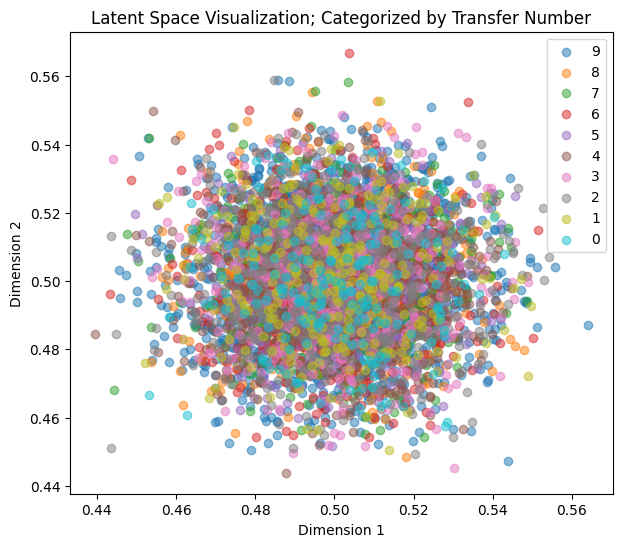

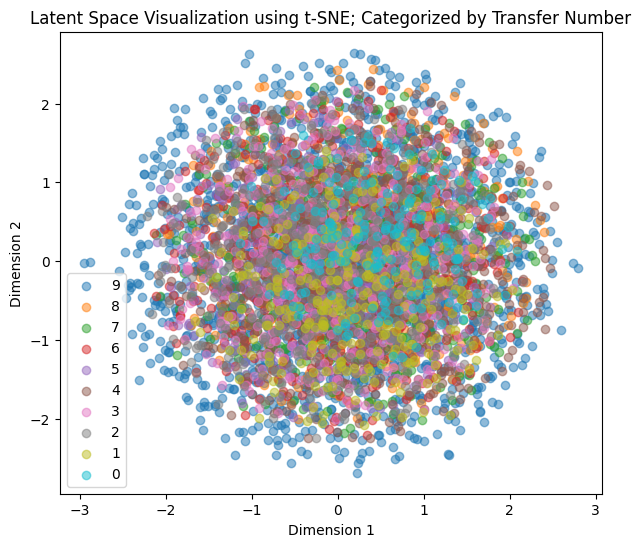

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100, random_state=42)

print(means.shape)
print(log_var.shape)
print(z.shape)
X = z_tn.mean(dim=1).detach().cpu().numpy()

splt = split_data(z_tn, [200, 500, 1000, 1500, 2140, 2500, 3000, 3500, 4000, 4350])

for i in range(len(splt)):
    temp = splt.pop(i).mean(dim=1).detach().cpu().numpy()
    splt.insert(i, temp)

splt_tsne=[]
for i in range(len(splt)):
    splt_tsne.append(tsne.fit_transform(splt[i]))


plt.figure(figsize=(7, 6))
for i in reversed(range(len(splt))):
    plt.scatter(splt[i][:, 0], splt[i][:, 1], alpha=0.5, label=i)

plt.legend()
plt.title("Latent Space Visualization; Categorized by Transfer Number")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


plt.figure(figsize=(7, 6))
for i in reversed(range(len(splt_tsne))):
    plt.scatter(splt_tsne[i][:, 0], splt_tsne[i][:, 1], alpha=0.5, label=i)
plt.legend()
plt.title("Latent Space Visualization using t-SNE; Categorized by Transfer Number")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


NameError: name 'z_tn0_tsne' is not defined

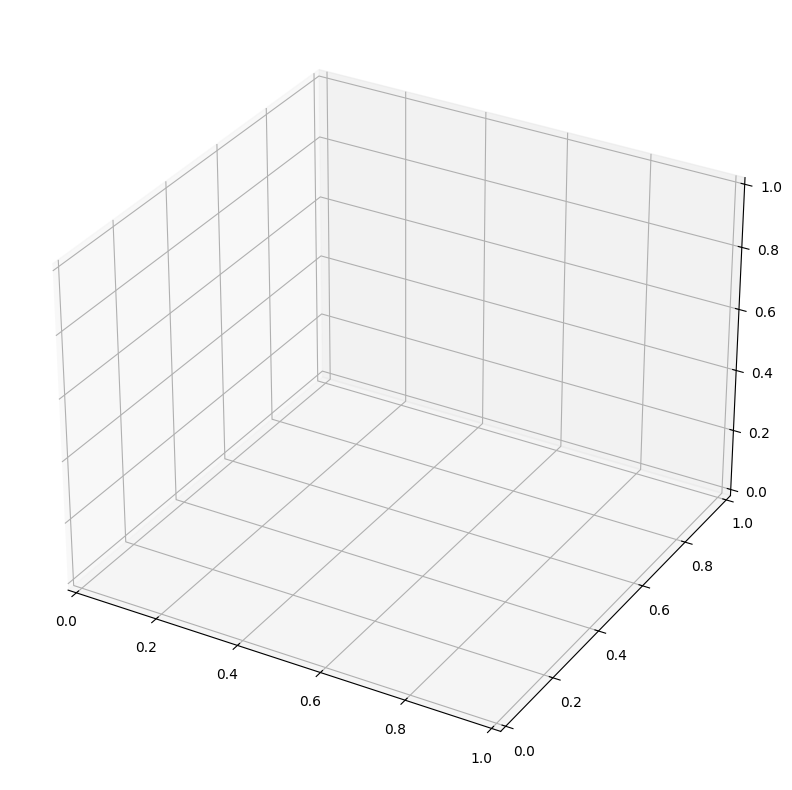

In [23]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

# 3D 플롯 그리기 위한 준비
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

groups = [z_tn0_tsne, z_tnm_tsne, z_tn022_tsne, z_tn05_tsne]

# 각 그룹마다 밀도 함수 계산 및 서피스 플롯
colors = ['Greys', 'Blues', 'Greens', 'Reds']
for i, (data, cmap) in enumerate(zip(groups, colors)):
    # 각 그룹 데이터의 x, y 분리
    x = data[:, 0]
    y = data[:, 1]

    # KDE 계산 : 2차원 밀도 추정기 객체 생성
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    
    # x, y 좌표 격자(grid) 생성
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xgrid = np.linspace(x_min, x_max, 100)
    ygrid = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(xgrid, ygrid)
    
    # 각 격자점에서 밀도 계산
    grid_coords = np.vstack([X.ravel(), Y.ravel()])
    Z = kernel(grid_coords)
    Z = Z.reshape(X.shape)
    Z = (1000 * Z)+1
    Z = np.log10(Z+1e-6)

    # 그룹별로 3D 서피스 플롯
    ax.plot_surface(X, Y, Z, cmap=cmap, alpha=0.3, edgecolor="grey")
    

# 3D 플롯 옵션 설정
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Density')
ax.set_title('3D Density Surfaces for 4 Transfer Number Groups')
ax.view_init(elev=40,azim=60)
plt.show()

In [ ]:
z_tn05_pooled = z_tn05.detach().cpu().numpy()
z_tn022_pooled = z_tn022.detach().cpu().numpy()
z_tn0_pooled = z_tn0.detach().cpu().numpy()
z_tnm_pooled = z_tnm.detach().cpu().numpy()

z_tn05_tsne = tsne.fit_transform(z_tn05_pooled)
z_tn022_tsne = tsne.fit_transform(z_tn022_pooled)
z_tn0_tsne = tsne.fit_transform(z_tn0_pooled)
z_tnm5_tsne = tsne.fit_transform(z_tnm_pooled)



plt.figure(figsize=(7, 6))
plt.scatter(z_tnm5_tsne[:, 0], z_tnm5_tsne[:, 1], alpha=0.5, label="Under 0")
plt.scatter(z_tn0_tsne[:, 0], z_tn0_tsne[:, 1], alpha=0.5, label="Over 0 ~ 0.22")
plt.scatter(z_tn022_tsne[:, 0], z_tn022_tsne[:, 1], alpha=0.5, label="0.22 ~ 0.5")
plt.scatter(z_tn05_tsne[:, 0], z_tn05_tsne[:, 1], alpha=0.5, label="Over 0.5")
plt.legend()
plt.title("Latent Space Visualization using t-SNE; Categorized by Transfer Number")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


ValueError: Found array with dim 3. TSNE expected <= 2.